# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

In [1]:
import numpy as np
tab1 = np.zeros(100)
tab2 = np.zeros([10, 20])
tab3 = np.arange(100)
# print(tab1)
# print(tab2)
# print(tab3)

In [2]:
import numpy as np

data = np.loadtxt('us_births_69_88.csv', skiprows=1, delimiter=',', dtype=int)
# print(data) 

days_data = []
for row in data:
    days_data.append(row[2])
    
MAX = max(days_data)
# print(MAX)
DAYS = len(days_data)
# print(DAYS)

In [3]:
import random as rnd


def random_day():
    while True:
        temp_res = rnd.randint(0, DAYS - 1)
        temp_high = rnd.randint(1, MAX)
        if days_data[temp_res] >= temp_high:
            return temp_res

25.692137199999998


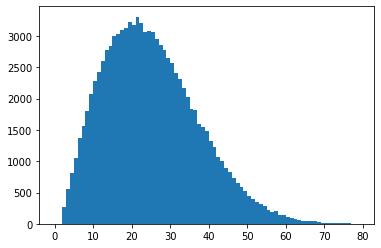

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import timeit as tit

def random_dates(range_limit, random_function=rnd.randint):
    d = range_limit
    result = set()
    while True:
        temp = random_function()
        if temp in result:
            break
        else:
            result.add(temp)
    return len(result) + 1

bins = range(80)
NUMBER_OF_SAMPLES = 100000

start_time = tit.default_timer()
results = []
for i in range(NUMBER_OF_SAMPLES):
    results.append(random_dates(DAYS, random_function=random_day))
print(tit.default_timer() - start_time)
    
plt.figure(1)
plt.hist(results, bins)
plt.show()

**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

In [5]:
RANDOM_SIZE = 1000
np_days_data = data[:,2]
DAYS = len(np_days_data)

def np_random_day():
    np_random_day.index += 1
    if np_random_day.index == len(np_random_day.buffer):
        np_random_day.index = 0
        np_random_day.np_days = np.random.randint(1, DAYS, RANDOM_SIZE)
        np_random_day.np_highs = np.random.randint(1, MAX, RANDOM_SIZE)
        np_random_day.buffer = np_random_day.np_days[np_days_data[np_random_day.np_days - 1] >= np_random_day.np_highs]
    return np_random_day.buffer[np_random_day.index]


# initialize buffer for this function
np_random_day.index = 0
np_random_day.np_days = np.random.randint(1, DAYS, RANDOM_SIZE)
np_random_day.np_highs = np.random.randint(1, MAX, RANDOM_SIZE)
np_random_day.buffer = np_random_day.np_days[np_days_data[np_random_day.np_days - 1] >= np_random_day.np_highs]

4.707883600000002


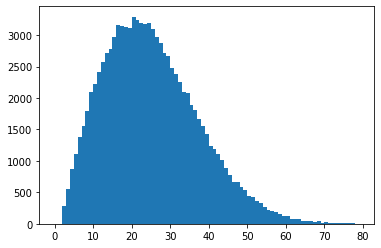

In [6]:
start_time = tit.default_timer()
results2 = []
for i in range(NUMBER_OF_SAMPLES):
    results2.append(random_dates(DAYS, random_function=np_random_day))
print(tit.default_timer() - start_time)
    
plt.figure(2)
plt.hist(results2, bins)
plt.show()

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

In [7]:
import queue as Q

# we need to filter in this case the invalid days because they damage
# the transfering process and all the statistics
# we know that amnong values equal to avg+-6σ we should find 99,9999998% of all proper 
# data so we filter to this value
# np_days_data = np.extract(np_days_data >= np.average(np_days_data) - 6 * np.std(np_days_data), np_days_data)
DAYS = len(np_days_data)

np_scaled_data = DAYS * np_days_data

AVG = int(np.average(np_scaled_data))
differ = np_scaled_data - AVG

mapping = np.arange(DAYS)
how_much_got = np.zeros(DAYS).astype(int)

bigger_indexes = np.where(differ > 0)
smaller_indexes = np.where(differ <= 0)

bigger_q = Q.Queue()
smaller_q = Q.Queue()

for data in bigger_indexes[0]:
    bigger_q.put(data)
    
for data in smaller_indexes[0]:
    smaller_q.put(data)
    
while not smaller_q.empty():
    b_index = bigger_q.get()
    s_index = smaller_q.get();
    assert mapping[s_index] == s_index
    how_much_got[s_index] = abs(differ[s_index])
    if differ[b_index] == abs(differ[s_index]):
        differ[b_index] = 0
    elif differ[b_index] > abs(differ[s_index]):
        differ[b_index] = differ[b_index] - abs(differ[s_index])
        bigger_q.put(b_index)                                            
    elif differ[b_index] < abs(differ[s_index]):
        differ[b_index] = differ[b_index] - abs(differ[s_index])
        smaller_q.put(b_index)
    differ[s_index] = 0
    mapping[s_index] = b_index
        
        
differ = np_scaled_data - AVG
got_after_giving = np.where(differ >= 0, how_much_got, 0)   # columns with possitive differ 
                                                            # but from which there was taken more data
                                                            # than its difference from average value
HIT_VALUES = AVG + np.where((got_after_giving == 0) & (differ < 0), differ, (-1) * got_after_giving)

assert ((HIT_VALUES <= AVG).all())

def np_random_day_always():
    np_random_day_always.index += 1
    if np_random_day_always.index == len(np_random_day_always.buffer):
        np_random_day_always.np_days = np.random.randint(0, DAYS, RANDOM_SIZE)
        np_random_day_always.np_highs = np.random.randint(1, AVG + 1, RANDOM_SIZE)
        np_random_day_always.index = 0
        np_random_day_always.buffer = np.where(np_random_day_always.np_highs <= HIT_VALUES[np_random_day_always.np_days], 
                                               np_random_day_always.np_days, 
                                               mapping[np_random_day_always.np_days])
    return np_random_day_always.buffer[np_random_day_always.index]

# initialize buffer for this function
np_random_day_always.np_days = np.random.randint(0, DAYS, RANDOM_SIZE)
np_random_day_always.np_highs = np.random.randint(1, AVG + 1, RANDOM_SIZE)
np_random_day_always.index = 0
np_random_day_always.buffer = np.where(np_random_day_always.np_highs <= HIT_VALUES[np_random_day_always.np_days], 
                                       np_random_day_always.np_days, 
                                       mapping[np_random_day_always.np_days])

4.954401999999995
24.50027


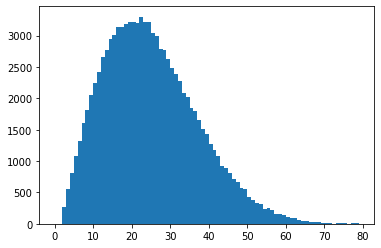

In [8]:
from statistics import mean

start_time = tit.default_timer()
results3 = []
for i in range(NUMBER_OF_SAMPLES):
    results3.append(random_dates(DAYS, random_function=np_random_day_always))
print(tit.default_timer() - start_time)
    
plt.figure(3)
plt.hist(results3, bins)
print(mean(results3))
plt.show()


**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.

**BONUS**. An alternative plotting library: plotly

In [ ]:
# install plotly with: pip install plotly
# you can run this shell command directly from Jupyter, by prefixing it with !
# usage: !pip install plotly

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import numpy as np

init_notebook_mode(connected=False)

# example scatterplot

x = np.linspace(0, 10, 11)
y = x**2

iplot([go.Scatter(x=x, y=y, name="y=x^2"), go.Scatter(x=x, y=-y, name="y=-x^2")])

# example heatmap

iplot([go.Heatmap(z=[[10, 20, 30, 40],
                      [20, 30, 40, 50],
                      [30, 40, 50, 60]])])